# Google Hashcode 2019 Final Round: Compiling Google

In [1]:
import numpy as np
import io
import pathlib
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
config InlineBackend.figure_format = 'retina'

## Utility Functions

In [3]:
def open_input(filename):
    # read file
    path=str(pathlib.Path().absolute())+"/dataset/"+filename
    input_file = io.open(path, mode='r')
    Lines = input_file.readlines() #lista di righe del file sorgente
    input_file.close()

    # parsing first line
    [num_file,num_target,num_server] = np.fromstring(Lines[0], dtype=int, sep=' ')

    # conversion of read lines from list of string to list of lists 
    Lines = [i.strip("[]\n").split(" ") for i in Lines]

    # blank dicts
    time = {}
    dep = {}
    target = {}

    
    # build time & dep dicts
    row=1

    while row <= num_file*2:
        time.update({Lines[row][0] : [Lines[row][1], Lines[row][2]]})
        row_dep=row+1

        if Lines[row_dep][0]== "0":
            dep.update({Lines[row][0]: []})
        else:
            num_dep=int(Lines[row_dep][0])
            dep.update({Lines[row][0]: Lines[row_dep][-num_dep:]})

        row+=2

        
    # build target dict     
    row=1+num_file*2

    while row <= num_target+(num_file*2):
        target.update({Lines[row][0] : [Lines[row][1], Lines[row][2]]})
        row+=1;

    # conversion dicts lists from string to int
    time = dict((k,list(map(int,v))) for k,v in time.items())
    target = dict((k,list(map(int,v))) for k,v in target.items())

    # generate file list
    file=list(time.keys())

    return num_file, num_target, num_server, file, time, dep, target

In [4]:
#creates the matrix of execution sequences
def create_sequence(num_server, target, dep): 
    
    # INPUT
    # num_serv: number of servers
    # target: dictionary of target's files
    # dep: dictionary of file's dependencies
    
    # OUTPUT
    # matrix: matrix of execution sequences
    
    # number of files target
    num_target = len(target)
    # list of target files
    target_keys = list(target.keys())
    # declaration of emtpy matrix
    matrix = []
    
   
    matrix_dim = min(num_server,num_target)
    # insert a target file for each matrix' row 
    for i in range(matrix_dim):
        row = []
        row.append(target_keys[i])
        matrix.append(row)
    
    # declaration of empty list of nodes. Contains nodes that must be inserted in a matrix' row
    nodes = []
    # declaration of empty list of files. Contains files that have already been inserted in matrix
    file_list = []
    
    # continues filling the matrix with dependencies of file targets
    for i in range(matrix_dim):
        nodes.append(matrix[i][0])
        
        while len(nodes) != 0:
            dep_list = dep[nodes[0]]
            
            for f in dep_list:
                # check whether the dependency file is already being compiled on a server or not
                if not(f in file_list):
                    matrix[i].insert(0,f)
                    file_list.append(f)
                    nodes.append(f)
                    
            nodes.pop(0)  
        
    return matrix

In [5]:
# creates list of target files that do not generates dependencies
def find_target(target, dep):
    no_dep_tar = []
    
    for key_tar in target:
        no_dep = True
        
        for key_dep in dep:
            if key_tar in dep[key_dep]:
                no_dep = False
                break
                
        if no_dep:
            no_dep_tar.append(key_tar)
    return no_dep_tar

In [6]:
def build_graph(time, dep, sequence):
    # Define the directed graph of the files
    graph = nx.DiGraph()

    # Add the nodes of the graph
    for server in sequence:
        graph.add_nodes_from(server)

    # Add the edges of the graph
    for server in sequence:    
        # add an edge between files on the same server
        for i in range(len(server)-1):
            w = time[server[i]][0]
            graph.add_edge(server[i], server[i+1], weight=w, n_weight=-w, color="black")
        # add dipendencies edges for each file on a server
        for i in range(len(server)):       
            dep_files = dep[server[i]]
            # check that the files has dipendencies
            if dep_files: 
                for f in dep_files:
                    # check that the file is on an other server
                    if f not in server:
                        w = time[f][0]+time[f][1]
                        graph.add_edge(f, server[i], weight=w, n_weight=-w, color="black")

    # Add two fake nodes
    graph.add_node("s")
    graph.add_node("t")

    for node in list(graph.nodes):
        if (node!="s" and node!="t"):
            # if node doesn't have in-edges, add edge s -> node
            if not graph.in_edges(node):
                graph.add_edge("s", node, weight=0, n_weight=0, color="black")
            # if node doesn't have out-edges, add edge node -> t
            elif not graph.out_edges(node):
                w = time[node][0]
                graph.add_edge(node, "t", weight=w, n_weight=-w, color="black")    
    
    return graph;

In [7]:
def get_longest_path(graph):
    # Get the longest path using negative weights 
    distance, path = nx.algorithms.shortest_paths.weighted.single_source_bellman_ford(graph, "s", weight="n_weight")
    # change the color of the edge on the path
    for key,value in path.items():
        if len(value)>1:
            for i in range(len(value)-1):
                graph[value[i]][value[i+1]]["color"] = "red"
    
    return graph, path;

In [9]:
def draw_graph(graph):
    # Draw graph
    fig = plt.figure(figsize=(10,6))
    ax = plt.axes()
    # graph layout
    pos = nx.planar_layout(graph)
    # draw nodes
    cmap = plt.get_cmap('Pastel1')
    # https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html <----- visit here for others color maps
    colors = [cmap(i) for i in np.linspace(0, 1, len(sequence)+1)]
    for i,server in enumerate(sequence):
        nx.draw_networkx_nodes(graph, pos, ax=ax, nodelist=server, node_color=[colors[i]], alpha=1, edgecolors="black")
    nx.draw_networkx_nodes(graph, pos, ax=ax, nodelist=["s","t"], node_color=[colors[len(sequence)]], alpha=1, edgecolors="black")
    nx.draw_networkx_labels(graph, pos, ax=ax);
    # draw edges
    color = nx.get_edge_attributes(graph,'color')
    nx.draw_networkx_edges(graph, pos, ax=ax, width=1.0, alpha=0.8, edge_color=color.values())
    edge_labels = nx.get_edge_attributes(graph,'weight')
    nx.draw_networkx_edge_labels(graph, pos, ax=ax, edge_labels=edge_labels, label_pos=0.5)

    plt.show()
    
    return graph

# DOUBTS
* Ho fatto in modo da dare alla matrice tante righe per quanti sono il minimo di target o server. Se però ho più server che target alcuni server perdono tempo senza lavorare.
* Ho preso i file target da assegnare in ordine di come si presentavano all'interno della lista target. Non sono convinto del fatto che usando invece i file target senza dipendenze le prestazioni siano migliori. Bisogna inoltre tenere in conto che se scegliessimo questa strada avremmo ancora meno server a lavorare (inoltre va modificato il codice).
* La soluzione che trovo in questo caso, con due server, non è una soluzione ottima ovviamente ma non sono sicuro che sia ammissibile. In che senso la soluzione trovata dev'essere ammissibile?
* Non sono sicuro che il codice abbia una complessità decente.

# Main Algorithm

In [10]:
num_file, num_target, num_server, file, time, dep, target = open_input("a_example.in")
sequence = create_sequence(num_server, target, dep)

C:\Users\fabio\Anaconda3\lib\site-packages\networkx\drawing\layout.py:923: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))
C:\Users\fabio\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\fabio\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
C:\Users\fabio\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and w

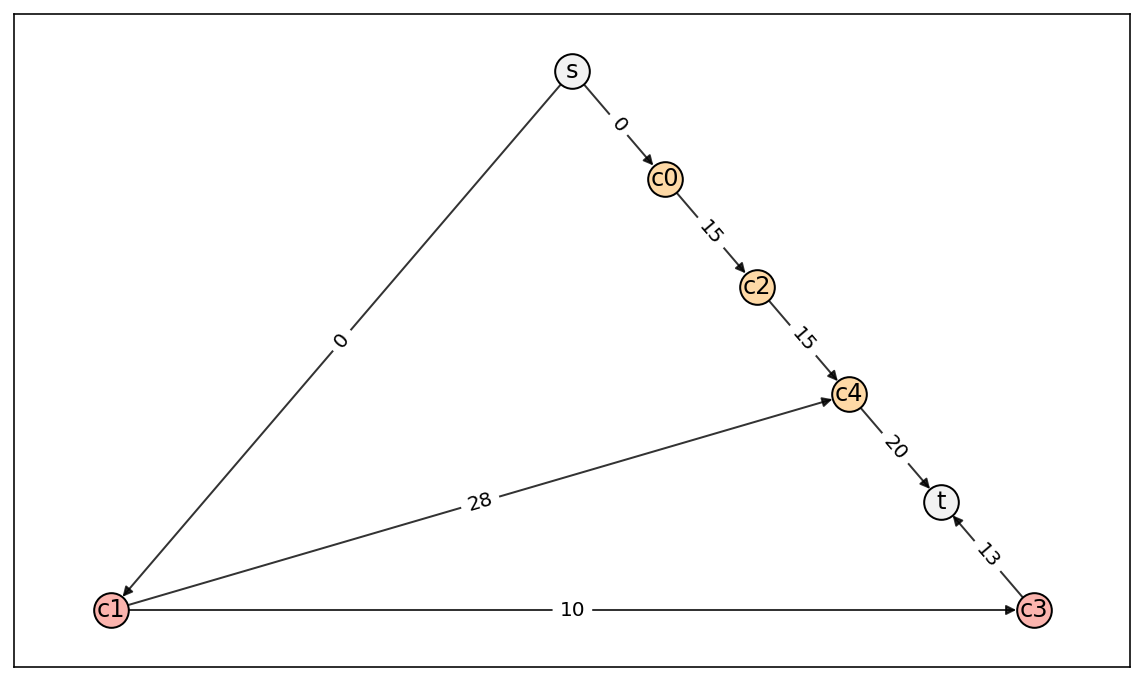

In [11]:
graph = build_graph(time, dep, sequence)
graph = draw_graph(graph)

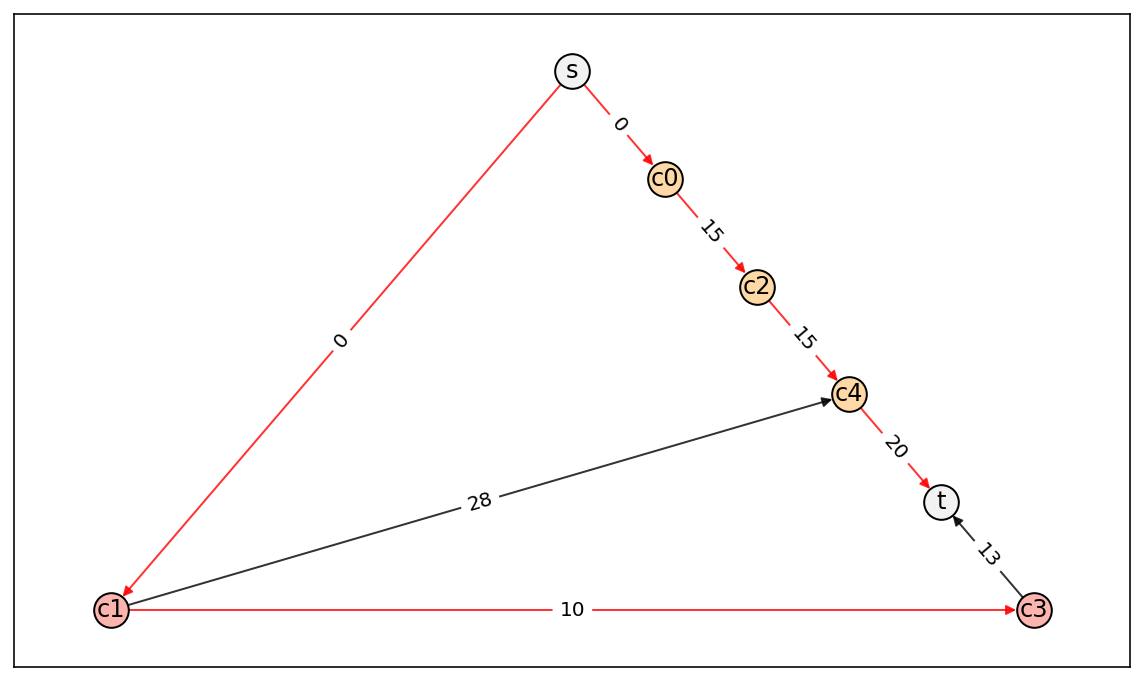

In [12]:
graph, path = get_longest_path(graph)
graph = draw_graph(graph)